In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors 
import seaborn as sns; sns.set(color_codes=True)

In [2]:
LRTAnalysis = uproot.open("/data/newhouse/LRT/batch/testing/testing_21p0_v7_doR3LargeD0/TTBAR/LRTAnalysis_output.root")
LRTAnalysis_nn = uproot.open("/data/newhouse/LRT/batch/testing/testing_21p0_v7_doR3LargeD0_funcnn_p2/TTBAR/LRTAnalysis_output.root")

In [3]:
event_branches = ['nTracks',
                  'nTruth',
                  'nTracksAccept',
                  'nTruthAccept',
                  'mu',
                  'event',
                  'mcid',
                  'isLRTrack',
                  'd0',
                  'isFake',
                 ]
event_tree_nn = LRTAnalysis_nn['Trees/eventTree'].pandas.df(event_branches, flatten=False)
event_tree_nn['nTracksLRT'] = event_tree_nn.isLRTrack.apply(sum)
event_tree_nn['nTracksStandard'] = event_tree_nn.nTracksAccept - event_tree_nn.nTracksLRT

event_tree = LRTAnalysis['Trees/eventTree'].pandas.df(event_branches, flatten=False)
event_tree['nTracksLRT'] = event_tree.isLRTrack.apply(sum)
event_tree['nTracksStandard'] = event_tree.nTracksAccept - event_tree.nTracksLRT

In [4]:
for tree in [event_tree, event_tree_nn]:
    tree['nTracksLRT_d0_2'] = 0
    tree['nTracksStandard_d0_2'] = 0
    tree['nTracksLRT_d0_5'] = 0
    tree['nTracksStandard_d0_5'] = 0
    for i in range(len(tree)):
        tree.loc[i, 'nTracksLRT_d0_2'] = ( 
            (abs(tree.iloc[i].d0) <= 2) 
            & (tree.iloc[i].isLRTrack == True)
            ).sum()
        tree.loc[i, 'nTracksStandard_d0_2'] = ( 
            (abs(tree.iloc[i].d0) <= 2) 
            & (tree.iloc[i].isLRTrack == False)
            ).sum()
        tree.loc[i, 'nTracksLRT_d0_5'] = ( 
            (abs(tree.iloc[i].d0) <= 5) 
            & (tree.iloc[i].isLRTrack == True)
            ).sum()
        tree.loc[i, 'nTracksStandard_d0_5'] = ( 
            (abs(tree.iloc[i].d0) <= 5) 
            & (tree.iloc[i].isLRTrack == False)
            ).sum()

In [ ]:
truth_branches=[
'truth_link',
'truth_type',
'truth_nSiHits',
'truth_nPixHits',
'truth_status',
'truth_fidPass',
'truth_r',
'truth_phi',
'truth_dphi',
'truth_z',
'truth_pt',
'truth_qOp',
'truth_d0',
'truth_z0',
'truth_eta',
'truth_barcode',
'truth_charge',
'truth_pdgId',
'truth_parentIdLLP',
'truth_parentId',
'truth_VSIorigin',
]
# truth_tree = LRTAnalysis['Trees/eventTree'].pandas.df(truth_branches)
# truth_tree_nn = LRTAnalysis_nn['Trees/eventTree'].pandas.df(truth_branches)

track_branches = [
'isFake',
'isSignal',
'truth_origin',
'index',
'truth_matchProb',
'pt',
'qOp',
'eta',
'd0',
'z0',
'link',
'isLRTrack',
'radiusOdFirstHit',
'nSiHits',
'nPixHits',
'nTRTHits',
'nPixHoles',
'nSiHoles',
'nPixShared',
'nSiShared',
'nContribPixLay',
'nPixOutliers',
'nSiOutliers',
'nTRTOutliers',
'chiSquared',
'nDOF',
'passLoose',
'passTight',
]
# track_tree = LRTAnalysis['Trees/eventTree'].pandas.df(track_branches)
# track_tree_nn = LRTAnalysis_nn['Trees/eventTree'].pandas.df(track_branches)

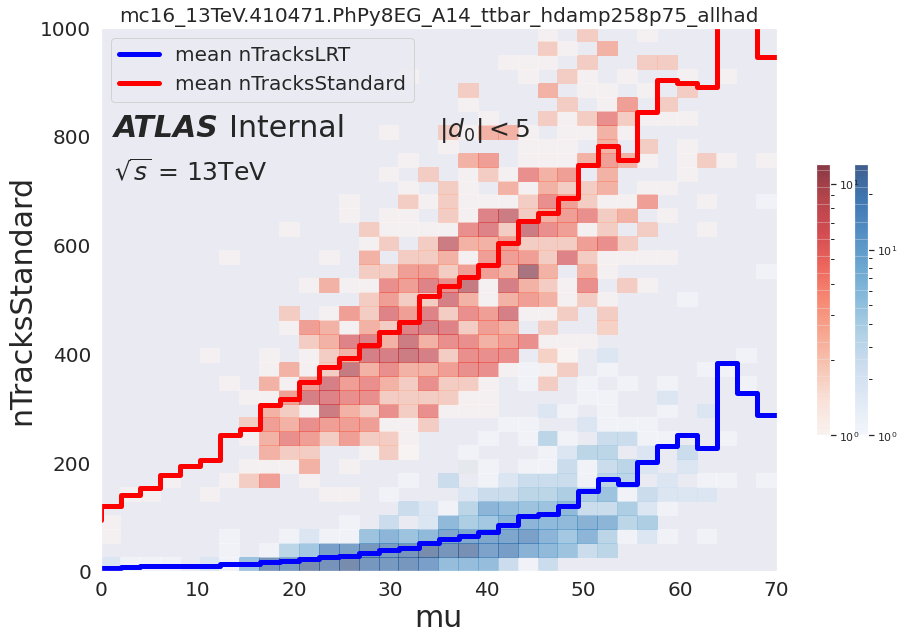

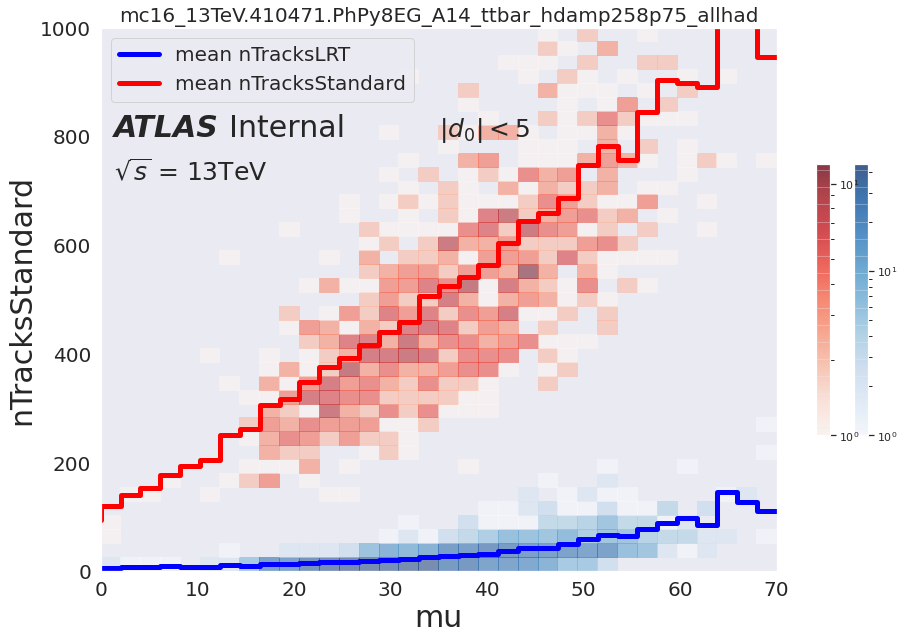

In [8]:
def plot2d(df, var_a, var_b, ax=None, nentries=1000, bins=[10,10], linecolor='darkred', histcolor='Reds'):
    
    if ax is None:
        fig = plt.figure(figsize=[15,10])
        ax = fig.gca()
    
    # draw 2d hist
    h, xedges, yedges, image = ax.hist2d(x=df[0:nentries][var_a], 
                                         y=df[0:nentries][var_b], 
                                         bins=bins,
                                         norm=colors.LogNorm(),
                                        alpha=0.5,
                                        cmap=histcolor,
                                        )
    # draw mean line across bins
    mean_tracks = []
    for i in bins[0]:
        mean_tracks.append(df.query(f'{var_a} > {i} & mu < {i+1}')[var_b].mean())
    ax.step(bins[0], mean_tracks, linewidth=5, color=linecolor)
    # set labels and tick parameters
    ax.set_xlabel(var_a, fontsize=30)
    ax.set_ylabel(var_b, fontsize=30)
    ax.legend([f'mean {var_b}'], fontsize=20, loc='upper left')
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_title('mc16_13TeV.410471.PhPy8EG_A14_ttbar_hdamp258p75_allhad', fontsize=20)
    return ax, image

def do_plot_ntrk(df):
    # define bins
    bins = [np.linspace(0,70,35), np.linspace(0,1000,40)]
    # plot 2d plot for LRT
    ax, image = plot2d(df, 'mu', 'nTracksLRT', bins=bins, linecolor='blue', histcolor='Blues')
    plt.colorbar(image, pad=-.05, shrink=0.5, fraction=.1, )
    # plot 2d plot for Standard
    ax, image = plot2d(df, 'mu', 'nTracksStandard', bins=bins, ax=ax, linecolor='red', histcolor='Reds')
    plt.colorbar(image, pad= .05, shrink=0.5, fraction=.1, )
    # define legend
    ax.legend(['mean nTracksLRT', 'mean nTracksStandard' ], fontsize=20, loc='upper left')
    # additional labels
    ax.text(.02, .8, "ATLAS", style='italic', fontweight='bold', fontsize=30, transform=ax.transAxes)
    ax.text(.19, .8, "Internal", fontsize=30, transform=ax.transAxes)
    ax.text(.02, .72, "$\sqrt{s}$ = 13TeV", fontsize=25, transform=ax.transAxes)
    ax.text(.5, .8, "$|d_0| < 5$", fontsize=25, transform=ax.transAxes)

    
do_plot_ntrk(event_tree)
do_plot_ntrk(event_tree_nn)

In [7]:
### ignore this, just a script for rerunning jobs


in_dirs = [
#     "VH4b", 
#     "TTBAR", 
#     "HNL",
#     "RPVLF", 
    ]
directory = '/data/newhouse/LRT/batch/testing/testing_21p0_v7_doR3LargeD0_funcnn_p2/'
for signal in in_dirs:
    for i in np.arange(5):
        if signal == "RPVLF" and i >= 3: continue
        for j in np.arange(20):
            filename = f'{directory}{signal}/{i}/{j}/DAOD_IDTRKVALID.root'
            try: 
                nentries = uproot.open(filename)['CollectionTree'].numentries
                if not nentries == 100: 
                    print('event different than 100')
                    raise Exception
            except: 
#                 print(e)
                print(f"      qsub {directory}{signal}/{i}/{j}/submit.pbs")